# Gate based workflow

This notebook shows an example of how a gate based computation (in this case using `qiskit`) could be integrated into `qse`.

In [1]:
import qse
import numpy as np

from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import efficient_su2
from scipy.optimize import minimize
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from qiskit.circuit import QuantumCircuit

## Step 1: Create qbits object

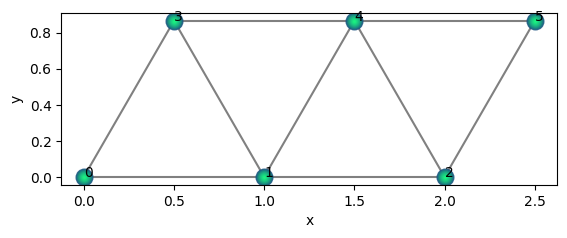

In [2]:
h = np.sqrt(1 - 0.5*0.5)

positions = np.array([
    [0., 0., 0.],
    [1., 0., 0.],
    [2., 0., 0.],
    [0.5, h, 0.],
    [1.5, h, 0.],
    [2.5, h, 0.],
    ])

qbits = qse.Qbits(positions=positions)
qbits.draw(show_labels=True, radius="nearest")

# Step 2: Define a distance function to create an interaction Hamiltonian that's based on the geometry of the qubits.

In [3]:
def distance_func(distance, tolerance=0.01):
    """
    Simple distance function that only includes nearest neighbours.
    
    This function returns a coefficient of 1.0 if the input distance is approximately 1.0
    (within a specified tolerance), otherwise it returns 0.0.
    """
    if np.abs(distance-1) < tolerance:
        return 1.
    return 0.

In [4]:
# simple ZZ coupling
coupling = qbits.compute_interaction_hamiltonian(distance_func, "Z")

# We can easily do something more complicated like a Heisenberg model:
# coupling = 
# qbits.compute_interaction_hamiltonian(distance_func, "X") + 
# qbits.compute_interaction_hamiltonian(distance_func, "Y") + 
# qbits.compute_interaction_hamiltonian(distance_func, "Z")


## Step 3: Run in qiskit
Here we use a simple VQE workflow.

In [5]:
hamiltonian = SparsePauliOp([i.to_str() for i in coupling], [i.coef for i in coupling])
print(hamiltonian)
ansatz = efficient_su2(qbits.nqbits, reps=1)

SparsePauliOp(['ZZIIII', 'ZIIZII', 'IZZIII', 'IZIZII', 'IZIIZI', 'IIZIZI', 'IIZIIZ', 'IIIZZI', 'IIIIZZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


In [6]:
def compute_expectation(params):
    """Compute the expectation value of a quantum operator using a statevector simulator."""
    estimator = StatevectorEstimator()

    pub = (ansatz, hamiltonian, params)
    job = estimator.run([pub])

    return job.result()[0].data.evs

def run_sampler(params, shots=1000):
    """Sample a circuit using a statevector simulator."""
    sampler = StatevectorSampler()

    circuit = QuantumCircuit(ansatz.num_qubits)
    circuit.append(ansatz, range(ansatz.num_qubits))
    circuit.measure_all()

    pub = (circuit, params)
    job = sampler.run([pub], shots=shots)

    return job.result()[0].data.meas.get_counts()

In [7]:
x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)

cost_hist = []
opt_result = minimize(
    compute_expectation, x0, method="BFGS", 
    callback=lambda intermediate_result: cost_hist.append(intermediate_result.fun)
    )
opt_result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -4.999999999949555
        x: [ 1.239e-06  2.015e-07 ...  1.955e+00  4.587e+00]
      nit: 22
      jac: [ 2.503e-06  6.557e-07 ...  0.000e+00  1.192e-07]
 hess_inv: [[ 5.229e-01  1.887e-02 ... -2.939e-04 -6.162e-05]
            [ 1.887e-02  1.047e+00 ... -4.146e-04 -1.414e-04]
            ...
            [-2.939e-04 -4.146e-04 ...  1.000e+00  6.489e-07]
            [-6.162e-05 -1.414e-04 ...  6.489e-07  1.000e+00]]
     nfev: 600
     njev: 24

In [8]:
samples = run_sampler(opt_result.x, shots=1000)
samples

{'010101': 1000}

## Step 4: Visualize results in qse

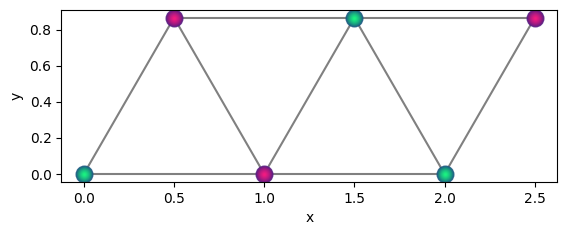

In [9]:
qbits.draw(colouring=list(samples.keys())[0], radius="nearest")